Margaux BAILLEUL 21906121 \
Clémence CHESNAIS 21901191

# Sujet : Analyse de sentiments des avis des lecteurs sur des livres 

Nous avons souhaité travailler sur la classification d’avis de livres car nous avons toutes les deux un attrait pour la lecture. Il nous a paru évident de travailler sur un sujet qui nous passionne car cela amène une dimension personnelle au projet. 

# Choix de la base de données

Au départ, nous avons souhaité utiliser une API pour récupérer les données nécessaires à notre analyse et construire nous même notre base de données. Pour cela, nous nous sommes orientées vers des sites et applications tels que GoodReads, Google livres, Openlibrary, API fnac ou encore API Amazon. Cependant, nous avons rencontré des difficultés dans la création des clés d’API. En effet, la plupart des accès étaient payants ou, dans le cas de GoodReads, la création de clés n'était plus possible depuis 2020.

Notre choix s'est donc orienté vers des bases de données déjà construites. Le site Kaggle dispose d’un nombre conséquent de base de données très variées. Après quelques recherches, nous avons eu le choix entre deux bases de données sur les avis de lecteurs : “French Book review” et “Amazon Books Reviews”. Cependant, cette dernière possède un nombre très important de lignes (environ 3 millions), ce qui nous a empêché de travailler sur celle-ci. En effet, nous avons fait le choix de travailler avec GitHub pour se partager plus facilement les codes. Or, le fichier étant trop lourd, il nous a été impossible de s’envoyer et de se partager le code. Malgré la richesse de cette base de données, le traitement aurait pris un temps trop conséquent.

Ainsi, nous avons retenu la base de données “French Book Review”, sur des avis (français) de livre.

# Import des modules

Nous allons importer tous les modules que nous allons utiliser au cours de ce projet. 

In [115]:
import pandas as pd 
import numpy as np
import regex as re
from collections import Counter
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import FrenchStemmer 
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Nous installons la dernière version de spacy ainsi que le modèle de langue française. \
Nous créons ensuite une variable nlp qui nous permet de charger le modèle de langue française préalablement téléchargé. La variable nlp devient un objet de traitement spaCy configuré pour le français.

In [116]:
!pip install -U spacy
!python -m spacy download fr_core_news_sm
import spacy
nlp = spacy.load('fr_core_news_sm')

     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
     --------------------------------------- 0.0/16.3 MB 330.3 kB/s eta 0:00:50
     --------------------------------------- 0.0/16.3 MB 330.3 kB/s eta 0:00:50
     --------------------------------------- 0.1/16.3 MB 585.1 kB/s eta 0:00:28
      --------------------------------------- 0.3/16.3 MB 1.4 MB/s eta 0:00:12
     - -------------------------------------- 0.6/16.3 MB 2.0 MB/s eta 0:00:08
     - -------------------------------------- 0.8/16.3 MB 2.4 MB/s eta 0:00:07
     -- ------------------------------------- 1.0/16.3 MB 2.7 MB/s eta 0:00:06
     -- ------------------------------------- 1.2/16.3 MB 2.8 MB/s eta 0:00:06
     --- ------------------------------------ 1.5/16.3 MB 3.0 MB/s eta 0:00:05
     ---- ----------------------------------- 1.7/16.3 MB 3.0 MB/s eta 0:00:05
     ---- ----------------------------------- 2.0/16.3 MB 3.1 MB/s eta 0:00:05
     ----- ---------------------------------- 2.2/16.3 M

# 1. Importation des données

Nous importons notre jeu de données qui s'intitule 'french_books_reviews.csv' puis nous visualisons ses 5 premières lignes.

In [117]:
data = pd.read_csv('french_books_reviews.csv', sep=',')
data.head()

,Unnamed: 0,book_title,author,reader_review,rating,label
0,0,Le Démon de la Colline aux Loups,Dimitri Rouchon-Borie,Ce n'est pas le premier roman à aborder les th...,5.0,1
1,1,Simple,Marie-Aude Murail,"Simple, alias Barnabé, est un jeune homme de 2...",4.0,1
2,2,La plus secrète mémoire des hommes,Mohamed Mbougar Sarr,Pour écrire La plus secrète mémoire des hommes...,4.0,1
3,3,Trancher,Amélie Cordonnier,« La violence d'Aurélien est revenue. Par la f...,3.5,0
4,4,"La guerre d'Alan, tome 2",Emmanuel Guibert,"Dans ce second album de La Guerre d’Alan, Emma...",5.0,1


Dans ce jeu de données nous disposons de 3 variables qualitatives et 2 variables quantitatives. 
Pour notre étude, nous avons le titre du livre, les noms et prénoms des auteurs, l'avis du lecteur, la note qu'il a attribué au livre ainsi qu'un label correspondant à la polarité de l'avis. Si l'avis est positif, le label vaut 1, s'il est neutre, il vaut 0 et s'il est négatif, il vaut -1. \
Notons que les noms des livres ainsi que les commentaires sont bien en français.

## 1.1. Statistiques descriptives

Tout d'abord, nous commençons par regarder si la base de données contient des valeurs manquantes.

In [118]:
data["reader_review"].isna().sum()

13

13 lignes contiennent des valeurs manquantes. Nous décidons de les supprimer car elles ne représentent que 0.1% de la base de données.
De plus, nous souhaitons étudier les avis des clients, il n'y a donc pas d'intérêt à garder les lignes où il n'y a pas d'avis.

In [119]:
data = data.dropna(subset=['reader_review'])

Nous vérifions qu'il ne reste plus de ligne sans avis.

In [120]:
data["reader_review"].isna().sum()

0

Nous regardons maintenant le nombre d'avis pour chacune des polarités.

In [121]:
data["label"].value_counts()

polarity_distribution= (pd.DataFrame.from_dict(Counter(data.label.values),
                                             orient='index')
                                  .rename(columns={0: 'nb_reviews'}))
polarity_distribution.index.name = 'class'
polarity_distribution

,nb_reviews
class,
1,6658
0,2129
-1,858


Dans ce jeu de données, il y a 6658 positifs, 2129 neutres et 858 négatifs.

Ensuite, nous allons calculer le pourcentage d'avis pour chaque polarité.

In [122]:
polarity_distribution['pourcentage'] = np.around(polarity_distribution.nb_reviews /
                                                np.sum(polarity_distribution.nb_reviews),
                                                2)
polarity_distribution

,nb_reviews,pourcentage
class,,
1,6658,0.69
0,2129,0.22
-1,858,0.09


Nous représentons sur un graphique la distributions des polarités selon le nombre d'avis.

<Axes: title={'center': "Nombre d'avis par classe"}, xlabel='class'>

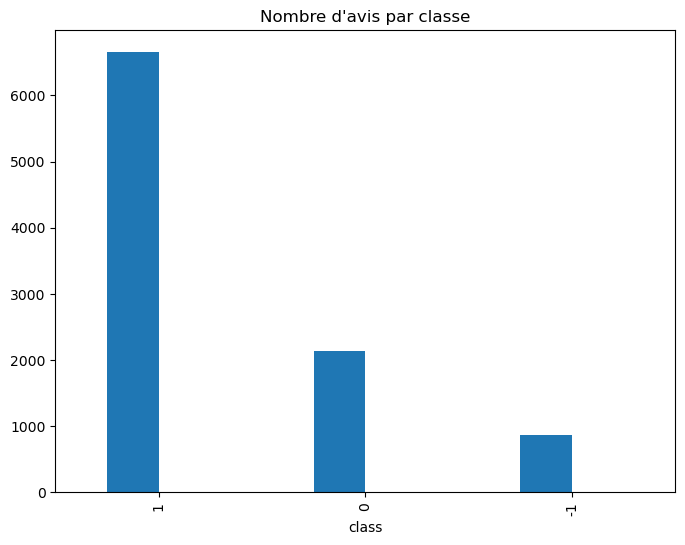

In [123]:
polarity_distribution.plot(kind='bar', figsize=(8, 6), legend=False, 
                           title="Nombre d'avis par classe")

Graphiquement, nous observons bien qu'il y a beaucoup plus d'avis positifs que d'avis neutres ou négatifs.

Nous affichons les 10 premiers avis pour voir à quoi ressemble les données.


In [124]:
for i in list(data['reader_review'][0:10]):
    print(i)
    print('------------------------')

Ce n'est pas le premier roman à aborder les thèmes lourds de l'inceste et de l'enfance martyre, mais il le fait avec une audace et un brio incomparables qui rendent ce livre marquant dans une vie de lecteur. On y sent à quel point l'auteur n'a pas cherché à "faire quelque chose", on ne sent jamais l'intention, on sent juste l'urgence, incandescente, à raconter la vérité d'un homme maltraité par la vie au point de dire à la nuit «  tu ne me feras pas peur j'ai plus de noir que toi dans mon enfance ».
------------------------
Simple, alias Barnabé, est un jeune homme de 22 ans qui a l’âge mental d’un enfant de 3 ans. Kléber, son frère de 17 ans, entre en terminale au lycée, mais décide de s’occuper lui-même de son frère. Leur mère étant morte et leur père refusant de s’encombrer de sa progéniture afin de vivre pleinement sa nouvelle vie, Kléber refuse d’abandonner son frère à Malicroix, l’institution où il dépérissait. Se mettant tant bien que mal à la recherche d’un appartement pour viv

On remarque que certains avis ne sont pas réellement des avis mais un résumé du livre ou une citation de celui-ci. Ces derniers devraient être classé dans la catégorie neutre.

## 1.2. Séparation des données

Nous séparons les données en deux jeux de données : un jeu d'entrainement et un jeu de test.

In [125]:
# On mélange les lignes du DataFrame
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# On utilise la fonction train_test_split pour diviser le DataFrame
train_df, test_df = train_test_split(data, train_size=2/3, random_state=42)

# On affiche les informations sur les ensembles d'entraînement et de test
print("Taille de l'ensemble d'entraînement :", len(train_df))
print("Taille de l'ensemble de test :", len(test_df))

Taille de l'ensemble d'entraînement : 6430
Taille de l'ensemble de test : 3215


# 2. Prétraitement des données

## 2.1 Lemmatisation

Lemmatiser un texte implique de réduire chaque mot à sa forme de base ou à son "lemme".
Cela implique la suppression des variations grammaticales (comme les temps verbaux, les genres, les nombres, etc.) pour regrouper les mots qui ont la même signification de base. 

La lemmatisation est souvent utilisée pour améliorer la précision de l'analyse en réduisant les variations de mots à leur forme canonique. Cela aide à regrouper les mots apparentés et à réduire la complexité lors de l'analyse textuelle. 

In [126]:
def lemmatisation(text):
    text = nlp(text)
    lemmas = [token.lemma_ for token in text]
    return ' '.join(lemmas)

On applique la lemmatisation sur les avis des livres des jeux de données d'aprentissage et de test. Le résultat de cette lemmatisation sera stocké dans une nouvelle colonne. 

In [127]:
train_df['lemme'] = train_df['reader_review'].apply(lemmatisation)

In [128]:
for i in list(train_df['lemme'][0:5]):
    print(i)
    print('------------------------')

le 26èm opus de aventure de San antonio réunir avec son acolyte préférer , Bérurier et Pinaud ( qui en prennent pour son grade de ailleurs ) ne figurer pas dans le meilleur de le série . le enquête se dérouler à Paris en partir de Halles , en passer par un bureau de Poste , le commissariat et quelque hôtel . un classique de le époque dire on , un investigation sur quelque jour dans le capitale et notre commissaire qui ne hésit pas à se salir le main pour découvrir le vérité . quant aux femme .... lui ne apprécier pas ce tome !
------------------------
«    mais alors ! le père Noël exister -t il ?   » , pour - raton se demander à le lecture de ce guide qui donne envie de s’ offrir enfin à soi - même de cadeau utile ? pouvoir - être , mais ce qu’ il y avoir de certain , c’ être qu’ on y parler très peu de le mère Noël qui avoir perdre son châle .
------------------------
je retrouver avec beaucoup de joie l’ auteure , Marjane satrapi m’ avoir éblouir par son maturité dans Persépolis et 

Nous faisons la même chose pour le jeu de données de test.

In [129]:
test_df['lemme'] = test_df['reader_review'].apply(lemmatisation)

In [130]:
for i in list(test_df['lemme'])[0:5]:
    print(i)
    print('------------------------')

troisième aventure de Tori et son mage .
------------------------
et s’ il falloir choisir celui qui être sauver ?
------------------------
se attaquer à 667 page ( dense ) de ce biographie de Fouché pouvoir apparaître comme un challenge . mais le talent de historien de Emmanuel de Waresquiel avoir vite faire de donner le envie de parcourir ce ouvrage avec détermination !
------------------------
ce ouvrage plaire à petit comme à grand , à adepte de beal livre illustrer comme à sorcière et sorcier en herbe .
------------------------
livre fantastique remplir de émotion de début à le fin . le lecture de un chapitre me donner envie de connaître le suite . je avoir dévorer ce livre . par contre , quand le fin arriver , quel tristesse de laisser ce personnage . je avoir envier de continuer un petit bout de chemin avec lui .
------------------------


Nous remarquons que la lemmatisation a bien fonctionné.

## 2.2. Racine des mots

Nous remplaçons les mots par leur racine. Cela permet de réduire la complexité lors de l'analyse textuelle.

In [131]:
def stem_text(text):
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    stemmer = FrenchStemmer('french')
    stems = [stemmer.stem(token) for token in tokenizer.tokenize(text)]
    return ' '.join(stems)

De la même manière, nous créons une nouvelle colonne qui contiendra le texte racinisé. 

In [132]:
train_df['stems'] = train_df['reader_review'].apply(stem_text)

In [133]:
for i in list(train_df['stems'])[0:5]:
    print(i)
    print('------------------------')

le 26em opus des aventur de san antonio réun avec ses acolyt préfer , béruri et pinaud ( qui en prennent pour leur grad d'ailleur ) ne figur pas dans les meilleur de la ser . l'enquêt se déroul à paris en part des hall , en pass par des bureau de post , le commissariat et quelqu hôtel . un classiqu de l'époqu dir on , des investig sur quelqu jour dans la capital et notre commissair qui n'hésit pas à se sal les main pour découvr la vérit . quant aux femm ... elle n'appréci pas ce tom !
------------------------
« mais alor ! le per noël existera-t-il ? » , pour-raton se demand à la lectur de ce guid qui don envi de s ’ offrir enfin à soi-mêm des cadeau util ? peut-êtr , mais ce qu ’ il y a de certain , c ’ est qu ’ on y parl tres peu de la mer noël qui a perdu son châl .
------------------------
je retrouv avec beaucoup de joi l ’ auteur , marjan satrap m ’ avait éblou par sa matur dans persépol et je la retrouv tout auss excellent dans poulet aux prun . on débarqu à téhéran en 1958 , on

Nous faisons la même chose pour le jeu de données de test.

In [134]:
test_df['stems'] = test_df['reader_review'].apply(stem_text)

In [135]:
for i in list(test_df['stems'][0:5]):
    print(i)
    print('------------------------')

troisiem aventur de tor et ses mag .
------------------------
et s ’ il fall chois ceux qui seraient sauv ?
------------------------
s'attaqu aux 667 pag ( dens ) de cet biograph de fouch peut apparaîtr comm un challeng . mais le talent d'historien d'emmanuel de waresquiel a vit fait de don l'env de parcour cet ouvrag avec détermin !
------------------------
cet ouvrag plair aux petit comm aux grand , aux adept de beau livr illustr comm aux sorci et sorci en herb .
------------------------
livr fantast rempl d'émot du début à la fin . la lectur d'un chapitr me don envi de connaîtr la suit . j'ai dévor ce livr . par contr , quand la fin arriv , quel tristess de laiss ces personnag . j'av envi de continu un pet bout de chemin avec eux .
------------------------


Nous remarquons bien que la racinisation a fonctionné. Nous remarquons également la différence avec la lemmatisation. 

## 2.3. Etiquetage morphosyntaxique

Cela va nous permettre d'attribuer des étiquettes grammaticales à chaque mot dans une phrase, indiquant ainsi leur catégorie grammaticale ou leur rôle dans la phrase. 

In [136]:
def replace_words_with_pos_tag(text):
    text = nlp(text)
    return ' '.join([token.pos_ for token in text])

In [137]:
train_df['pos'] = train_df['reader_review'].apply(replace_words_with_pos_tag)

In [138]:
for i in list(train_df['pos'][0:5]):
    print(i)
    print('------------------------')

DET ADJ NOUN ADP NOUN ADP PROPN NOUN VERB ADP DET NOUN VERB PUNCT PROPN CCONJ PROPN PUNCT PRON PRON NOUN ADP DET NOUN ADP ADV PUNCT ADV VERB ADV ADP DET NOUN ADP DET NOUN PUNCT DET NOUN PRON VERB ADP PROPN ADP VERB ADP PROPN PUNCT ADP VERB ADP DET NOUN ADP PROPN PUNCT DET NOUN CCONJ DET NOUN PUNCT DET NOUN ADP DET NOUN VERB PRON PUNCT DET NOUN ADP DET NOUN ADP DET NOUN CCONJ DET NOUN PRON ADV ADJ ADV ADP PRON VERB DET NOUN ADP VERB DET NOUN PUNCT ADV DET NOUN PUNCT PRON ADV VERB ADV DET NOUN PUNCT
------------------------
ADJ SPACE CCONJ ADV PUNCT DET NOUN PROPN AUX PRON PRON PUNCT SPACE PUNCT PUNCT ADP PROPN ADJ PRON VERB ADP DET NOUN ADP DET NOUN PRON VERB NOUN ADP PROPN VERB ADV ADP PRON ADV ADV ADP NOUN ADJ PUNCT ADV ADV ADV PUNCT CCONJ PRON PROPN PRON PRON VERB ADP ADJ PUNCT NOUN AUX SCONJ PRON PRON VERB ADV ADV ADP DET NOUN PROPN PRON AUX VERB DET NOUN PUNCT
------------------------
PRON VERB ADP ADV ADP VERB ADJ VERB PUNCT PROPN DET NOUN AUX VERB ADP DET NOUN ADP PROPN CCONJ PRO

Nous faisons la même chose pour le jeu de données de test.

In [139]:
test_df['pos'] = test_df['reader_review'].apply(replace_words_with_pos_tag)

In [140]:
for i in list(test_df['pos'][0:5]):
    print(i)
    print('------------------------')

ADJ NOUN ADP PROPN CCONJ DET NOUN PUNCT
------------------------
CCONJ PRON PRON VERB NOUN PRON PRON AUX VERB PUNCT
------------------------
PRON VERB ADP NUM NOUN PUNCT ADJ PUNCT ADP DET NOUN ADP PROPN VERB VERB ADP DET NOUN PUNCT CCONJ DET NOUN ADP NOUN ADP PROPN ADP PROPN AUX ADV VERB ADP VERB DET NOUN ADP VERB DET NOUN ADP NOUN PUNCT
------------------------
DET NOUN VERB ADP ADJ ADP ADP NOUN PUNCT ADP NOUN ADP ADJ NOUN VERB ADP ADP NOUN CCONJ ADJ ADP NOUN PUNCT
------------------------
NOUN ADJ VERB ADP NOUN ADP NOUN ADP DET NOUN PUNCT DET NOUN ADP DET NOUN PRON VERB NOUN ADP VERB DET NOUN PUNCT PRON AUX VERB DET NOUN PUNCT ADP NOUN PUNCT SCONJ DET NOUN VERB PUNCT DET NOUN ADP VERB DET NOUN PUNCT PRON VERB VERB ADP VERB DET ADJ NOUN ADP NOUN ADP PRON PUNCT
------------------------


## 2.4. Entités nommées

Les entités nommées sont des éléments spécifiques dans un texte qui font référence à des personnes, des lieux, des organisations, des dates, des quantités, etc. L'identification et l'étiquetage des entités nommées sont essentiels dans le traitement automatique du langage naturel pour pouvoir extraire des informations clés d'un texte. 

Par exemple, dans un article de presse, repérer les noms des personnes, des lieux ou des organisations est crucial pour comprendre le contenu et ses acteurs.

In [141]:
def ner(text):
    text = nlp(text)
    new_text = []
    for token in text:
        if token.ent_iob_ == "O":
            new_text.append(token.text)
        elif token.ent_iob_ == "B":
            new_text.append(token.ent_type_)
        # Si l'entité comprend plusieurs mot on ne répète pas l'étiquette
        else:
            continue
    return ' '.join(new_text)

Pour expliquer cette fonction, nous prenons l'exemple avec la phrase suivante :
"Elle vit à Paris et travaille chez Google. Elle a rencontré John Doe à New York."

La fontion pour chaque mot donne le résultat suivant :

- "Elle" : "O" (Outside), car ce mot ne fait pas partie d'une entité nommée.

- "vit" : "O" (Outside), pas une entité nommée.

- "à" : "O" (Outside), pas une entité nommée.

- "Paris" :"B" (Beginning) et ent_type_ = "LIEU" , car c'est le début d'une entité nommée de type "LIEU".

- "et" : "O" (Outside), pas une entité nommée.

- "travaille" : "O" (Outside), pas une entité nommée.

- "chez" : "O" (Outside), pas une entité nommée.

- "Google" : "B" (Beginning) et ent_type_ = "ORGANISATION", car c'est le début d'une entité nommée de type "ORGANISATION".

- "." : "O" (Outside), pas une entité nommée.

- "Elle" : "O" (Outside), pas une entité nommée.

- "a" : "O" (Outside), pas une entité nommée.

- "rencontré" : "O" (Outside), pas une entité nommée.

- "John" : "B" (Beginning) et ent_type_ = "PERSONNE", car c'est le début d'une entité nommée de type "PERSONNE".

- "Doe" : "I" (Inside) et ent_type_ = "PERSONNE", car c'est la suite d'une entité nommée de type "PERSONNE".

- "à" : "O" (Outside), pas une entité nommée.

- "New" : "B" (Beginning) et ent_type_ = "LIEU", car c'est le début d'une entité nommée de type "LIEU".

- "York" : "I" (Inside) et ent_type_ = "LIEU", car c'est la suite d'une entité nommée de type "LIEU".

- "." : "O" (Outside), pas une entité nommée.


Les entités de type I ne sont pas affichées.
Pour les mots de type B, ils seront remplacées par le type de l'entité nommée. Par exemple, "Paris" sera remplacé par "LIEU".

On aura donc la phrase suivante :

"Elle vit à LIEU et travaille chez ORGANISATION. Elle a rencontré PERSONNE à LIEU."

Nous appliquons cette fonction sur les jeux de données d'apprentissage et de test.

In [142]:
train_df['entites_nommees'] = train_df['reader_review'].apply(ner)

In [143]:
for i in list(train_df['entites_nommees'][0:5]):
    print(i)
    print('------------------------')

Le 26ème opus des aventures de San Antonio réuni avec ses acolytes préférés , PER et PER ( qui en prennent pour leur grade d' ailleurs ) ne figure pas dans les meilleurs de la série . L' enquête se déroule à LOC en partant des LOC , en passant par des bureaux ORG , le commissariat et quelques hôtels . Un classique de l' époque dirait on , des investigations sur quelques jours dans la capitale et notre commissaire qui n' hésite pas à se salir les mains pour découvrir la vérité . Quant aux femmes .... elle n' apprécieront pas ce tome !
------------------------
«    Mais alors ! Le père MISC existera -t -il ?   » , pour - raton se demander à la lecture de ce guide qui donne envie de PER offrir enfin à soi - même des cadeaux utiles ? Peut - être , mais ce qu’ il y a de certain , MISC est LOC on y parle très peu de la mère MISC qui a perdu son châle .
------------------------
Je retrouve avec beaucoup de joie l’ auteure , MISC PER avait ébloui par sa maturité dans LOC et je la retrouve tout

In [144]:
test_df['entites_nommees'] = test_df['reader_review'].apply(ner)

In [145]:
for i in list(test_df['entites_nommees'][0:5]):
    print(i)
    print('------------------------')

Troisième aventure de LOC et ses mages .
------------------------
Et LOC il fallait choisir ceux qui seraient sauvés ?
------------------------
S' attaquer aux 667 pages ( denses ) de cette biographie de PER peut apparaître comme un challenge . Mais le talent d' historien d' PER a vite fait de donner l' envie de parcourir cet ouvrage avec détermination !
------------------------
Cet ouvrage plaira aux petits comme aux grands , aux adeptes de beaux livres illustrés comme aux sorcières et sorciers en herbe .
------------------------
livre fantastique rempli d' émotions du début à la fin . la lecture d' un chapitre me donnait envie de connaître la suite . j' ai dévoré ce livre . par contre , quand la fin arrive , quelle tristesse de laisser ces personnages . j' avais envie de continuer un petit bout de chemin avec eux .
------------------------


## 2.5. Traitement des URLS 

Nous remplaçons les URL par un mot fictif. En effet, les URL peuvent poser problème dans l'apprentissage du modèle. C'est pourquoi nous les remplaçons par un mot unique choisi au préalable.

In [146]:
def remplacer_url(text, url_replacement='urlexpr'):
    text = re.sub(r'https?:\S+', url_replacement, text) # http://t.co/eFKkE9W0GI
    text = re.sub(r'\bwww\.\S+', url_replacement, text) # www.example.com
    return text

In [147]:
train_df['sans_url'] = train_df['reader_review'].apply(remplacer_url)

In [148]:
for i in list(train_df["sans_url"][0:5]):
    print(i)
    print('------------------------')

Le 26ème opus des aventures de San Antonio réuni avec ses acolytes préférés, Bérurier et Pinaud (qui en prennent pour leur grade d'ailleurs) ne figure pas dans les meilleurs de la série. L'enquête se déroule à Paris en partant des Halles, en passant par des bureaux de Poste, le commissariat et quelques hôtels. Un classique de l'époque dirait on, des investigations sur quelques jours dans la capitale et notre commissaire qui n'hésite pas à se salir les mains pour découvrir la vérité. Quant aux femmes.... elle n'apprécieront pas ce tome !
------------------------
«  Mais alors ! Le père Noël existera-t-il ? », pour-raton se demander à la lecture de ce guide qui donne envie de s’offrir enfin à soi-même des cadeaux utiles ? Peut-être, mais ce qu’il y a de certain, c’est qu’on y parle très peu de la mère Noël qui a perdu son châle.
------------------------
Je retrouve avec beaucoup de joie l’auteure, Marjane Satrapi m’avait ébloui par sa maturité dans Persépolis et je la retrouve tout aussi

Nous faisons la même chose pour le jeu de données de test.

In [149]:
test_df['sans_url'] = test_df['reader_review'].apply(remplacer_url)

In [150]:
resultats = test_df[test_df['sans_url'].str.contains('urlexpr')]
resultats['sans_url']

1287                                       Insta: urlexpr
604     Si ce roman promettait d'être ingénieux et ori...
Name: sans_url, dtype: object

Nous voyons bien que les liens sont été remplacés par 'urlexp'.  

## 2.6 Suppression de certains mots

La suppression de certains mots comme les "mots vides", c'est-à-dire les mots qui n'apportent pas d'information pour la classification, permettent de se focaliser sur les mots les plus importants. Par exemple, les mots "et", "car", "le", "la"... n'apportent pas d'information. 
De plus, les modèles d'analyse de sentiments peuvent être sensibles à la dimensionnalité élevée des données. 

En réduisant le vocabulaire, on réduit le nombre de mots que le modèle doit prendre en compte, ce qui peut améliorer l'efficacité de l'apprentissage et la vitesse d'entraînement.
Certains mots peuvent apparaître rarement ou être spécifiques à des documents particuliers, ce qui peut introduire du bruit dans le modèle. 
Par ailleurs, en se concentrant sur les termes les plus fréquents et les plus informatifs, le modèle peut se généraliser plus efficacement à de nouveaux textes. Cela peut également contribuer à éviter le surajustement aux données d'entraînement.


In [151]:
sw = nltk.corpus.stopwords.words('french')
print(sw)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

Nous appliquerons ce corpus de mots vides à nos jeux de données d'apprentissage et de test dans la suite de notre étude.

# 3. Calcul des valeurs des descripteurs

## 3.1. Séparation du jeu de données d'entrainement en 2 jeux de données

Nous séparons le jeu de données d'entrainement en 2 jeux de données : un jeu de données d'entrainement et un jeu de données de validation. 

# FAIRE JUSTIFICATION DU CHOIX DE LA COLONNE ENTITE NOMMEES

In [152]:
from sklearn.model_selection import train_test_split

In [153]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df['reader_review'],
                                                      train_df['label'],
                                                      train_size=0.75,
                                                      random_state=5)

Pour le jeu de données tests, on met la variable label dans un objet "y_test" et la colonne "reader_review" dans un objet "X_test".

In [154]:
X_test, y_test = test_df['reader_review'], test_df['label']

## 3.2 Numérique discret : décompte d'occurences

La fonction CountVectorizer permet de compter le nombre d'occurences de chaque mot dans chaque avis. Elle transforme une liste de textes en une représentation numérique utilisable pour des algorithmes d'apprentissage automatique.

Le processus de fit consiste à analyser le texte pour déterminer les mots uniques présents dans X_train et à créer une représentation vectorielle de ces mots. Chaque texte sera représenté comme un vecteur où chaque élément correspond à la fréquence d'apparition de chaque mot du vocabulaire dans ce texte.

Ainsi, cela créé un objet "CountVectorizer" qui contient le vocabulaire de tous les mots de tous les avis.\ Cet objet est appelé "vect_count".

In [155]:
vect_count = CountVectorizer().fit(X_train)

On affiche les 50 premiers noms des mots utilisés pour créer la représentation vectorielle des textes :

In [156]:
vect_count.get_feature_names_out()[:50]

array(['000', '02', '03', '08', '10', '100', '1000', '1078', '109', '11',
       '112', '115', '12', '1200', '121', '125', '12ans', '12heures',
       '13', '130', '130kg', '130p', '14', '140', '141', '1415', '1425',
       '144', '14ans', '15', '150', '1518', '153', '15jours', '16', '160',
       '1600', '1604', '1613', '1615', '164', '165', '1664', '1665',
       '1691', '16ème', '17', '173', '1750', '1756'], dtype=object)

On affiche les 50 derniers noms des mots utilisés pour créer la représentation vectorielle des textes :

In [157]:
vect_count.get_feature_names_out()[-50:]

array(['évoquée', 'évoquées', 'évoqués', 'évènement', 'évènementielle',
       'évènements', 'événement', 'événements', 'êkho', 'êtes', 'être',
       'êtres', 'île', 'îles', 'ïnes', 'ôshi', 'ôte', 'örn', 'œdipe',
       'œdipienne', 'œil', 'œils', 'œuf', 'œufs', 'œuvre', 'œuvrent',
       'œuvres', 'œuvré', 'достоевский', 'михайлович', 'фёдор', '日光流年',
       '阎连科', '𝐻𝑒𝑎𝑟𝑡𝑠', '𝐽𝑒', '𝑁𝑜𝑒', '𝑇𝑎𝑖𝑛𝑡𝑒𝑑', '𝑎𝑖𝑚𝑒𝑟', '𝑓𝑒𝑟𝑎𝑖𝑠', '𝑡𝑒',
       '𝗟𝗮', '𝗰𝗵𝗼𝘀𝗲', '𝗱𝗶𝘀𝗽𝗼𝘀𝗲𝘀', '𝗲𝗻', '𝗲𝘁', '𝗽𝗿𝗼𝗽𝗼𝘀𝗲', '𝗾𝘂𝗲𝗹𝗾𝘂𝗲', '𝘁𝗲',
       '𝘁𝘂', '𝘃𝗶𝗲'], dtype=object)

In [158]:
len(vect_count.get_feature_names_out())

23492

Ainsi, nous créons une représentation vectorielle des données d'entraînement en se basant sur le vocabulaire établi précédemment. 

Donc, cette opération convertit les données textuelles en une matrice numérique où chaque ligne correspond à un texte et chaque colonne correspond à la fréquence d'un mot spécifique dans ce texte.

In [159]:
X_train_vectorized_count = vect_count.transform(X_train)
X_train_vectorized_count

<4822x23492 sparse matrix of type '<class 'numpy.int64'>'
	with 192491 stored elements in Compressed Sparse Row format>

X_train_count est une matrice de taille (n_train=4822, n_features=18634) où n_train est le nombre de textes dans le jeu de données d'entraînement et n_features est le nombre de mots dans le vocabulaire.

Nous faisons la même chose pour le jeu de données de validation et de test :

In [160]:
X_valid_vectorized_count = vect_count.transform(X_valid)
X_test_vectorized_count = vect_count.transform(X_test)

Nous créons un autre objet CountVectorizer mais cette fois-ci, nous posons certaines conditions : le mot doit apparaitre au moins 5 fois dans les documents pour être inclus dans le vocabulaie. De plus, les mots seront des unigrammes et des bigrammes.

In [161]:
vect_count_bigrams = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)
X_train_vectorized_count_bigrams = vect_count_bigrams.transform(X_train)
X_valid_vectorized_count_bigrams = vect_count_bigrams.transform(X_valid)
X_test_vectorized_count_bigrams = vect_count_bigrams.transform(X_test)

In [162]:
len(vect_count_bigrams.get_feature_names_out())

10483

Le nombre de mots dans le vocabulaire a diminué du fait des conditions ajoutées dans le CountVectorizer. Il est passé d'environ 18 600 à environ 10 000. 

## 3.3 Numérique continu : TF-IDF

Nous avons décidé de créer 2 objets tfidfVectorizer : un avec le paramètre stopwords (donc en supprimant les mots vides) et un sans le paramètre stopwords (on garde les mots vides). En effet, les mots entrés dans les stopwords peuvent être importants pour interpréter la polarité d'un avis.\

Par ailleurs, nous ajoutons dans notre représentation numérique les **bi-grammes**. En effet, ces derniers peuvent être importants pour interpréter la polarité d'un avis. Par exemple, "pas bien" est un bi-gramme qui donne une polarité négative alors que l'analyse du mot "bien" seul donnerait une polarité positive.

In [163]:
from sklearn.feature_extraction.text import TfidfVectorizer

### 3.3.1 Modèle avec suppression des stopwords

In [164]:
vect_tfidf_sw = TfidfVectorizer(min_df=5, stop_words=sw, ngram_range=(1,2)).fit(X_train)

In [165]:
len(vect_count.get_feature_names_out()), len(vect_tfidf_sw.get_feature_names_out())

(23492, 5507)

Pour le vocabulaire (numérique discret) il y a 18634 mots.

Pour le vocabulaire (numérique continu) il y a 5774 mots.

Pour rappel, nous avons supprimés les "stops words" du vocabulaire.

Nous décidons de carder le dictionnaire de vocabulaire numérique continu à 5774 mots, car cela permet de réduire la dimensionnalité des données (nombre de vocabulaire à apprendre) et donc de réduire le temps de calcul.

In [166]:
X_train_vectorized_tfidf_sw = vect_tfidf_sw.transform(X_train)
X_valid_vectorized_tfidf_sw = vect_tfidf_sw.transform(X_valid)
X_test_vectorized_tfidf_sw = vect_tfidf_sw.transform(X_test)

### 3.3.2 Modèle sans suppression des stopwords

In [167]:
vect_tfidf = TfidfVectorizer(min_df=5,ngram_range=(1,2)).fit(X_train)

In [168]:
len(vect_count.get_feature_names_out()), len(vect_tfidf.get_feature_names_out())

(23492, 10483)

Même conclusion ici, nous décidons de garder le dictionnaire de vocabulaire numérique continu à 18 634 mots. Ici, il y a plus de mots à apprendre car nous avons gardé les "stops words" et ajouté les bigrammes.

In [169]:
X_train_vectorized_tfidf = vect_tfidf.transform(X_train)
X_valid_vectorized_tfidf = vect_tfidf.transform(X_valid)
X_test_vectorized_tfidf = vect_tfidf.transform(X_test)

# 4. Classification sans suppression des stopwords 

Nous allons maintenant tester différents modèles et regarder leur accuracy afin de voir lequel d'entre eux est le plus performant et classifierait au mieux nos avis.

In [170]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 4.1. Modèles de référence faibles (*weak baselines*)

### 4.1.1. Choix aléatoire

In [171]:
from sklearn.dummy import DummyClassifier

In [172]:
random_prop_class = DummyClassifier(strategy='stratified').fit(X_train_vectorized_tfidf,
                                                               y_train)
predictions_valid = random_prop_class.predict(X_valid_vectorized_tfidf)
conf_mat = confusion_matrix(y_valid, predictions_valid)

In [173]:
print(conf_mat)

[[  7  33  79]
 [ 31  78 233]
 [ 95 208 844]]


In [174]:
accuracy_score(y_valid, predictions_valid)

0.5777363184079602

L'accuracy de ce premier modèle est de 55.53% ce qui signifie qu'il classe correctement un peu plus de la moitié de nos avis. Cela reste une performance moyenne.

In [175]:
random_uniform = DummyClassifier(strategy='uniform').fit(X_train_vectorized_tfidf,
                                                         y_train)
predictions_valid = random_uniform.predict(X_valid_vectorized_tfidf)
predictions_valid

array([ 1,  0,  1, ...,  1, -1,  1], dtype=int64)

In [176]:
conf_mat = confusion_matrix(y_valid, predictions_valid)

In [177]:
print(conf_mat)

[[ 36  52  31]
 [117 114 111]
 [393 385 369]]


In [178]:
accuracy_score(y_valid, predictions_valid)

0.32276119402985076

In [179]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.07      0.30      0.11       119
           0       0.21      0.33      0.26       342
           1       0.72      0.32      0.45      1147

    accuracy                           0.32      1608
   macro avg       0.33      0.32      0.27      1608
weighted avg       0.56      0.32      0.38      1608



La performance du modèle de classification est relativement faible. Il a du mal à bien classer les instances, comme en témoignent les faibles valeurs de précision, rappel et F1-score. L'exactitude est également basse. 

### 4.1.2. Prédiction constante de la classe majoritaire

In [180]:
polarity_distribution

,nb_reviews,pourcentage
class,,
1,6658,0.69
0,2129,0.22
-1,858,0.09


Nous allons vérifier notre réponse : 

In [181]:
maj = DummyClassifier(strategy='most_frequent').fit(X_train_vectorized_tfidf, y_train)
predictions_valid = maj.predict(X_valid_vectorized_tfidf)
predictions_valid

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [182]:
maj_class = (polarity_distribution.index[polarity_distribution.pourcentage ==
                                      np.amax(polarity_distribution.pourcentage)][0])
maj_class

1

Nous observons bien que la classe majoritaire est 1.

In [183]:
np.all(predictions_valid == maj_class)

True

In [184]:
maj.score(X_valid_vectorized_tfidf, y_valid)

0.7133084577114428

Nous avons environ 69% d'avis classés positifs. Cela reste donc normal que le score soit aux alentours de 71%, ce qui est proche de ce premier pourcentage. 

In [185]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       119
           0       0.00      0.00      0.00       342
           1       0.71      1.00      0.83      1147

    accuracy                           0.71      1608
   macro avg       0.24      0.33      0.28      1608
weighted avg       0.51      0.71      0.59      1608



c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Conclusion modèles de référence faibles
Ici, l'accuray du modèle faible n'est vraiment pas très bonne. Celle concernant la prédiction constante de la classe majoritaire est bonne mais c'est seulement car nous avons beaucoup d'avis positifs dans la base de données. Sinon, si le nombre d'avis dans chaque classe était plus homogène, l'accuracy aurait été bien inférieure. 

Nous allons donc continuer à tester d'autres modèles pour évaluer la performance. 

## 4.2. Classifieur bayésien naïf

In [186]:
from sklearn.naive_bayes import MultinomialNB

In [187]:
model_nb = MultinomialNB().fit(X_train_vectorized_tfidf, y_train)
predictions_valid = model_nb.predict(X_valid_vectorized_tfidf)

In [188]:
accuracy_score(y_valid, predictions_valid)

0.7139303482587065

Le modèle prédit correctement 71.33% des avis du jeu de données de validation.

On affiche la matrice de confusion pour le jeu de données de validation :

In [189]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02       119
           0       0.00      0.00      0.00       342
           1       0.71      1.00      0.83      1147

    accuracy                           0.71      1608
   macro avg       0.57      0.34      0.28      1608
weighted avg       0.58      0.71      0.60      1608



c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Le modèle a une précision élevée pour la classe 1 (71%), mais des performances très faibles pour les classes -1 et 0. Le rappel est particulièrement bas pour la classe -1. L'exactitude globale est de 71%, mais cela est largement dû à la prédominance de la classe 1. Le modèle peut être biaisé et nécessite une amélioration, en particulier pour mieux capturer les classes minoritaires.

## 4.3. Régression logistique

### 4.3.1. Premier modèle de régression logistique 

In [190]:
from sklearn.linear_model import LogisticRegression

In [191]:
model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                              max_iter=200).fit(X_train_vectorized_count, y_train)

c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [192]:
predictions_valid = model_lr.predict(X_valid_vectorized_count)

In [193]:
accuracy_score(y_valid, predictions_valid)

0.6716417910447762

Notre modèle de régression logistique prédit correctement 66.79% des avis du jeu de données de validation.

On affiche la matrice de confusion pour le jeu de données de validation :

In [194]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.26      0.12      0.16       119
           0       0.29      0.18      0.22       342
           1       0.75      0.88      0.81      1147

    accuracy                           0.67      1608
   macro avg       0.43      0.39      0.40      1608
weighted avg       0.61      0.67      0.63      1608



#### Association des mots avec les classes

In [195]:
def print_n_strongly_associated_features(vectoriser, model, n):
    feature_names = np.array(vectoriser.get_feature_names_out())

    for i in range(3):
        class_name = model.classes_[i]
        print("CLASSE {}".format(class_name))
        idx_coefs_sorted = model.coef_[i].argsort() # ordre croissant
        print("Les dix variables ayant l'association négative la plus forte " + 
              "avec la classe {} :\n{}\n".format(class_name,
                                                 feature_names[idx_coefs_sorted[:n]]))
        idx_coefs_sorted = idx_coefs_sorted[::-1] # ordre décroissant
        print("Les dix variables ayant l'association positive la plus forte " +
              "avec la classe {} :\n{}\n"
              .format(class_name,
                      feature_names[idx_coefs_sorted[:n]]))
        print()

### 4.3.2. Deuxième modèle de régression logistique

In [196]:
model_lr = LogisticRegression(multi_class='multinomial',
                              solver='lbfgs').fit(X_train_vectorized_tfidf, y_train)
predictions_valid = model_lr.predict(X_valid_vectorized_tfidf)

In [197]:
accuracy_score(y_valid, predictions_valid)

0.7189054726368159

La performance est meilleure que le premier modèle de régression logistique. En effet, le modèle prédit correctement 71.82% des avis du jeu de données de validation.

In [198]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.80      0.03      0.06       119
           0       0.51      0.06      0.10       342
           1       0.72      0.99      0.84      1147

    accuracy                           0.72      1608
   macro avg       0.68      0.36      0.33      1608
weighted avg       0.68      0.72      0.62      1608



### 4.3.3. Troisième modèle de régression logistique

Nous créons un modèle de régression logistique avec le vectoriseur à unigrammes et bigrammes.

In [199]:
model_lr = LogisticRegression(multi_class='multinomial', 
                              solver='lbfgs',
                              max_iter=500).fit(X_train_vectorized_count_bigrams, 
                                                y_train)
predictions_valid = model_lr.predict(X_valid_vectorized_count_bigrams)

In [200]:
accuracy_score(y_valid, predictions_valid)

0.6741293532338308

Ce modèle prédit correctement 67.85% des avis du jeu de données de validation.\
Sa performance est moins bonne que le deuxième modèle de régression logistique.

In [201]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.28      0.13      0.17       119
           0       0.35      0.25      0.29       342
           1       0.75      0.86      0.80      1147

    accuracy                           0.67      1608
   macro avg       0.46      0.41      0.42      1608
weighted avg       0.63      0.67      0.65      1608



Il y a plus d'erreur dans ce modèle. 

## 4.4 SVM

In [202]:
from sklearn.svm import SVC

In [203]:
model_svm = SVC(kernel='linear', 
                C=0.1).fit(X_train_vectorized_count_bigrams, 
                           y_train)

predictions_valid = model_svm.predict(X_valid_vectorized_count_bigrams)

In [204]:
accuracy_score(y_valid, predictions_valid)

0.6735074626865671

La performance de ce modèle est moins bonne que celle du modèle de régression logistique. En effet, le modèle prédit correctement 66.97% des avis du jeu de données de validation.

In [205]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.21      0.13      0.16       119
           0       0.32      0.15      0.21       342
           1       0.74      0.88      0.81      1147

    accuracy                           0.67      1608
   macro avg       0.42      0.39      0.39      1608
weighted avg       0.61      0.67      0.63      1608



# 5. Classification avec suppression des stopwords

Ici, nous n'allons pas reproduire tous les tests de modèles essayés précdemment. Nous allons simplement tester les 2 modèles avec la meilleure accuracy obtenue, pour voir si le fait de supprimer les stopwords a un impact sur notre modèle. \
Nous allons donc utiliser le deuxième modèle de régression logistique ainsi que celui avec le classifieur baïésien naïf, dont les deux accuracy sont à 71% environ.

## 5.1 Classifieur naïf baïésien

In [206]:
model_nb_sw = MultinomialNB().fit(X_train_vectorized_tfidf_sw, y_train)
predictions_valid_sw = model_nb_sw.predict(X_valid_vectorized_tfidf_sw)

In [207]:
accuracy_score(y_valid, predictions_valid_sw)

0.7133084577114428

Le modèle prédit correctement 71.45% des avis du jeu de données de validation. 

### Conclure pour ici mais j'ai pas les scores

## 5.2 Deuxième modèle de régression logistique

In [208]:
model_lr_sw = LogisticRegression(multi_class='multinomial',
                              solver='lbfgs').fit(X_train_vectorized_tfidf_sw, y_train)
predictions_valid_sw = model_lr_sw.predict(X_valid_vectorized_tfidf_sw)

In [209]:
accuracy_score(y_valid, predictions_valid_sw)

0.7120646766169154

Premièrement, le temps d'exécution des modèles avec et sans stopwords est identiques.\
De plus, la suppression des "stopwords" dans les avis du jeu de données n'a pas d'impact significatif sur notre modèle. En effet, les accuracy sont quasi similaire (à 0.0005 près).\
Le modèle Bayésien naif est légèrement plus performant quand on ne supprime pas les stopwords (mots ).

Globalement, le modèle avec le meilleur accuracy est le deuxième modèle de régression logistique en n'enlevant pas les stopwords, avec une accuracy de 71.82%.

Etant donné qu'il n'y a pas de différence significative entre les modèles avec et sans stopwords au niveau des accuracy, cela nous conforte dans l'idée de ne pas tester tous les autres modèles en supprimant les stopwords.

# 6. Visualisation

Maintenant que nous avons choisi notre modèle, nous pouvons visualiser les 10 mots les plus probables dans chacune des classes (positivement et négativement). 

In [214]:
print_n_strongly_associated_features(vect_count, model_lr_sw, 10)

CLASSE -1
Les dix variables ayant l'association négative la plus forte avec la classe -1 :
['bukowski' 'azincourt' 'aménémopé' 'albin' 'consistantes' 'boy'
 'cardiaque' 'chevelure' 'accord' '1972']

Les dix variables ayant l'association positive la plus forte avec la classe -1 :
['apothéose' 'apprécié' 'contentes' 'bombe' 'ami' 'chassant' 'baignée'
 'cady' 'calvino' 'contemplative']


CLASSE 0
Les dix variables ayant l'association négative la plus forte avec la classe 0 :
['ami' 'cf' 'confidente' 'blé' 'austin' 'acquiesce' 'conan' 'atlantide'
 'bientôt' 'agoniser']

Les dix variables ayant l'association positive la plus forte avec la classe 0 :
['antiquité' 'bardini' 'concrétisait' 'constant' 'boy' 'cendrars' 'chez'
 'considérable' 'concrètement' 'creusait']


CLASSE 1
Les dix variables ayant l'association négative la plus forte avec la classe 1 :
['contentes' 'apothéose' 'apprécié' 'bombe' 'bardini' 'contemplative'
 'blanche' 'colone' 'antiquité' 'comptines']

Les dix variables ayant 

Nous pouvons voir quel le résultat est très logique. En effet, si nous prenons l'exemple de la classe 1, nous pouvons voir que les mots les moins probables d'y être associés sont par exemple "déception" ou "déçue", tandis qu eles mots étant le plus probable d'être cités sont "magnifique" ou encore "excellent". À REFAIRE EN FONCTION DES RÉSULTATS

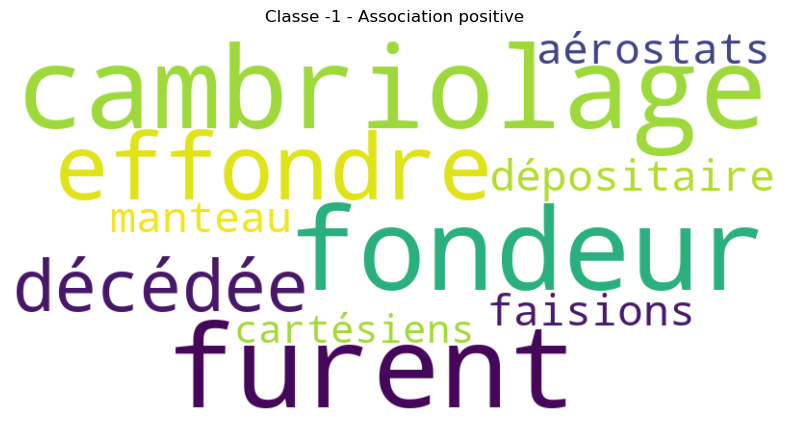

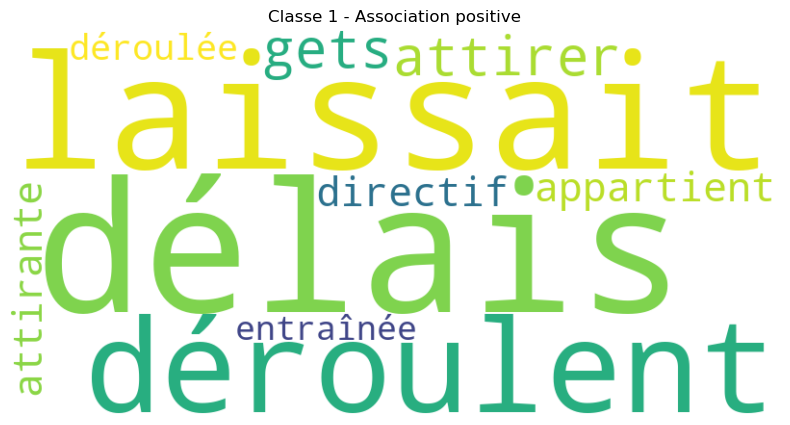

In [211]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Les listes de mots associées à chaque classe
mots_classe_pos_moins_1 = ['cambriolage', 'fondeur', 'furent', 'effondre', 'décédée', 'dépositaire', 'faisions', 'manteau', 'aérostats', 'cartésiens']
mots_classe_pos_1 = ['délais','laissait','déroulent','gets','attirer','appartient','attirante','directif','déroulée','entraînée']

# Fonction pour générer le nuage de mots
def generer_wordcloud(mots, titre):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(mots))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titre)
    plt.show()

# Générer les nuages de mots pour chaque classe
generer_wordcloud(mots_classe_pos_moins_1, "Classe -1 - Association positive")
generer_wordcloud(mots_classe_pos_1, "Classe 1 - Association positive")


# 7. Conclusion

Nous pouvons donc dire que le meilleur modèle est celui avec/sans les stopwords et celui qui utilise ??? (mettre meilleur modèle)

Cependant, notre matrice de confusion est possiblement biaisée. En effet, certains de nos avis sont des "résumés" des livres, et ils on été classés dans la base de donnée comme non neutres. 

On a testé avec les bigram et trigram car intéressant dans notre cas 

On a pris la colonne avec les entités nommées car cela ne nous apporte rien de savoir le nom ??

Si on teste avec une autre colonne : expliquer pourquoi 



Ce projet a donc été un réel plaisir à réaliser. Étant toutes les deux des grandes lectrices, nous avons pu rencontrer des livres que nous avons déjà lu. Cela nous a également fait découvrir d'autres livres, qui sont maintenant dans notre liste de lecture ! 😊 

- Ajouter le pb avec la colonne entité nommée --> mots en lien avec les classes aucun sens 
ET COMME LES ACCURACY SONT PROCHES ON A GARDER READER REVIEWS


CLASSE -1
Les dix variables ayant l'association négative la plus forte avec la classe -1 :
['lune' 'ailes' 'désuet' 'air' 'clarté' 'impatience' 'entremêlent'
 'chronologique' 'bin' 'investiront']

Les dix variables ayant l'association positive la plus forte avec la classe -1 :
['cambriolage' 'fondeur' 'furent' 'effondre' 'décédée' 'dépositaire'
 'faisions' 'manteau' 'aérostats' 'cartésiens']


CLASSE 0
Les dix variables ayant l'association négative la plus forte avec la classe 0 :
['directif' 'hâtif' 'larme' 'gourmand' 'gorgée' 'fortunes' 'entraînée'
 'continueront' 'heureux' 'bêtises']

Les dix variables ayant l'association positive la plus forte avec la classe 0 :
['brûlante' 'inédit' 'investigation' 'accordé' 'inspiré' 'clarté'
 'attendez' 'caractérise' 'lumière' 'autrement']


CLASSE 1
Les dix variables ayant l'association négative la plus forte avec la classe 1 :
['cambriolage' 'brûlante' 'fusionné' 'inédit' 'dissuadé' 'cartésiens'
 'hésitation' 'jalons' 'chipoter' '1974']
...
['délais' 'laissait' 'déroulent' 'gets' 'attirer' 'appartient' 'attirante'
 'directif' 'déroulée' 'entraînée']

# 7. Pour aller plus loin

Pour rappel, notre projet de la note en fonction de la polarité du commentaire laissé 

- **Personnalisation et recommandations:** Dans les systèmes de recommandation, la reconnaissance des entités nommées peut aider à comprendre les préférences des utilisateurs en identifiant les entités (comme des films, des livres, des lieux) mentionnées dans leurs interactions textuelles.
